## Imports

In [104]:
import numpy as np
import os
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

import torch
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

## Dataset

In [105]:
images = sorted(os.listdir(r".\data\NDD20\BELOW"))
masks = sorted(os.listdir(r"F:\Mask_RCNN_Finetuning\data\NDD20\BELOW_MASKS"))

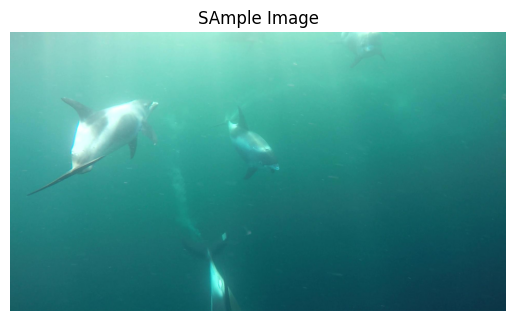

In [106]:
image = cv2.imread(r".\data\NDD20\BELOW\\" + "4.jpg")
rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.imshow(rgb_image)
plt.title('SAmple Image')
plt.axis('off')  # Hide the axis
plt.show()

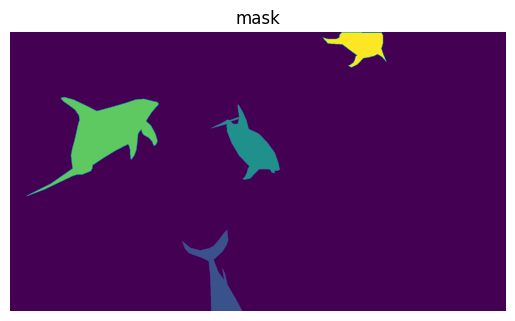

In [107]:
mask = cv2.imread(r".\data\NDD20\BELOW_MASKS\\" + "4_mask.png", cv2.IMREAD_GRAYSCALE)

plt.imshow(mask)
# plt.imshow(mask, 'gray')
plt.title('mask')
plt.axis('off')  # Hide the axis
plt.show()

In [108]:
np.unique(mask)

array([0, 1, 2, 3, 4], dtype=uint8)

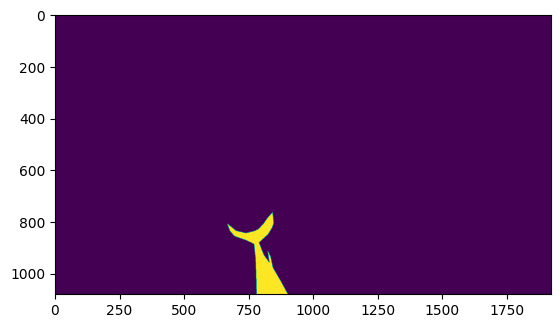

In [109]:
plt.imshow(np.array(mask) == 1)

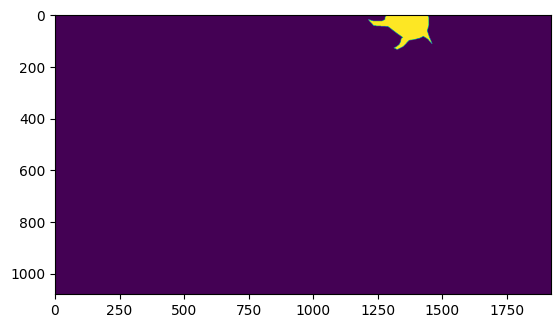

In [110]:
plt.imshow(np.array(mask) == 4)

In [111]:
data_transform = A.Compose(
    [
        A.Resize(width=130, height=130),
        A.RandomCrop(width=128, height=128),
        A.RandomRotate90(p=0.5),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.3),
        A.RGBShift(r_shift_limit=25, g_shift_limit=25, b_shift_limit=25, p=0.5),
        A.OneOf([
            A.Blur(blur_limit=3, p=0.5),
            A.ColorJitter(p=0.5),
        ], p=1.0),
        A.Normalize(
            mean=[0, 0, 0],
            std=[1, 1, 1],
            max_pixel_value=255,
        ),
        ToTensorV2(),
    ]
)

In [112]:
class DolphinDataset(torch.utils.data.Dataset):
    def __init__(self, images_dir, masks_dir, transformer=None):
        self.images_dir = images_dir
        self.masks_dir = masks_dir  
        self.imgs = os.listdir(images_dir)
        self.transformer = transformer

    def __getitem__(self, idx):
        img = Image.open(os.path.join(self.images_dir, self.imgs[idx])).convert("RGB")
        mask = Image.open(os.path.join(self.masks_dir, (self.imgs[idx].replace('.jpg', '_mask.png'))))
                          
        mask = np.array(mask)
        obj_ids = np.unique(mask)
        obj_ids = obj_ids[1:]
        num_objs = len(obj_ids)

        if self.transformer is not None:   
            augmentations = self.transformer(image=np.array(img), mask=mask)
            img = augmentations["image"]
            mask = augmentations["mask"]

        masks = np.zeros((num_objs , mask.shape[0] , mask.shape[1]))

        for i in range(num_objs):
            masks[i][mask == i+1] = True

        boxes = []

        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin , ymin , xmax , ymax])

        boxes = torch.as_tensor(boxes , dtype = torch.float32)
        labels = torch.ones((num_objs,) , dtype = torch.int64)
        masks = torch.as_tensor(masks , dtype = torch.uint8)
        
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks

       
        return  img, target
    
    def __len__(self):
        return len(self.imgs)

In [113]:
IMGS_DIR = r".\data\NDD20\BELOW"
MASKS_DIR = r".\data\NDD20\BELOW_MASKS"

In [114]:
dataset = DolphinDataset(images_dir=IMGS_DIR, masks_dir=MASKS_DIR, transformer=data_transform)

In [115]:
def custom_collate(data):
  return data

In [116]:
train_dl = torch.utils.data.DataLoader(
    dataset,
    batch_size=2,
    shuffle=True,
    collate_fn = custom_collate 
)

## Model

In [117]:
model = torchvision.models.detection.maskrcnn_resnet50_fpn()

In [118]:
model

MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=1e-05)
          (relu):

In [119]:
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features , 2)

in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
hidden_layer = 256
model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask , hidden_layer , 2)

In [120]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [121]:
model.to(device)

MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=1e-05)
          (relu):

## Train

In [ ]:
params = [p for p in model.parameters() if p.requires_grad]

In [ ]:
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

In [ ]:
all_train_losses = []
all_val_losses = []
flag = False

for epoch in range(10):
    train_epoch_loss = 0
    val_epoch_loss = 0
    model.train()

    for i ,dt in enumerate(train_dl):

        if len(dt) == 2:
            imgs = [dt[0][0].to(device) , dt[1][0].to(device)]
            targ = [dt[0][1], dt[1][1]]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targ]
            loss = model(imgs , targets)
        
        else:
            imgs = [dt[0][0].to(device)]
            targ = [dt[0][1]]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targ]
            loss = model(imgs , targets)

        if not flag:
            print(loss)
            flag = True

        losses = sum([l for l in loss.values()])
        train_epoch_loss += losses.cpu().detach().numpy()
        optimizer.zero_grad()
        losses.backward()
        
        optimizer.step()

    all_train_losses.append(train_epoch_loss/len(train_dl))

    print(epoch , "  " , train_epoch_loss/len(train_dl) )

In [ ]:
plt.plot(all_train_losses)

In [ ]:
path = 'saved_model.pth'
torch.save(model, path)

## Evaluation

In [ ]:
val_transform = A.Compose(
        [
            A.Resize(width=130, height=130),
            A.CenterCrop(width=128, height=128),
            A.Normalize(
                mean=[0.0, 0.0, 0.0],
                std=[1.0, 1.0, 1.0],
                max_pixel_value=255.0,
            ),
            ToTensorV2(),
        ],
    )

In [ ]:
model.eval()

image = cv2.imread(r".\data\NDD20\BELOW\139.jpg")

transformed_img = val_transform(image=image)['image']

with torch.no_grad():
    pred = model([transformed_img.to(device)])

In [ ]:
binary_masks = []

for mask in pred[0]["masks"]:
    mask = (mask.cpu().detach().numpy() * 255).astype("uint8").squeeze()
    threshold = 128
    binary_masks.append(np.where(mask > threshold, 1, 0))    

In [ ]:
final_mask = np.zeros((128, 128))

for i, binary_mask in enumerate(binary_masks):
    final_mask[binary_mask == 1] = i + 1

plt.imshow(final_mask)  
plt.axis('off')
plt.show()